# Waste Classification Using CNN

#### 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


# Import Keras and related libraries for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from glob import glob

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:20<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


### 2. Load DataSet

In [4]:
## Load & Read DataSet
train_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN"
test_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

### 3. Data Loading and Visualization (Exploration)

In [5]:
# Load images for visualization using cv2 and glob.
# (This segment is useful for EDA, but note that model training uses ImageDataGenerator.)
x_data = []
y_data = []

# Loop through each category folder in the training directory
for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        if img_array is None:
            continue  # Skip if image reading fails
        # Convert BGR to RGB for proper color display
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

100%|██████████| 12565/12565 [00:05<00:00, 2266.54it/s]


In [6]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

In [7]:
# Create a DataFrame for easy exploration
data = pd.DataFrame({'image': x_data, 'label': y_data})

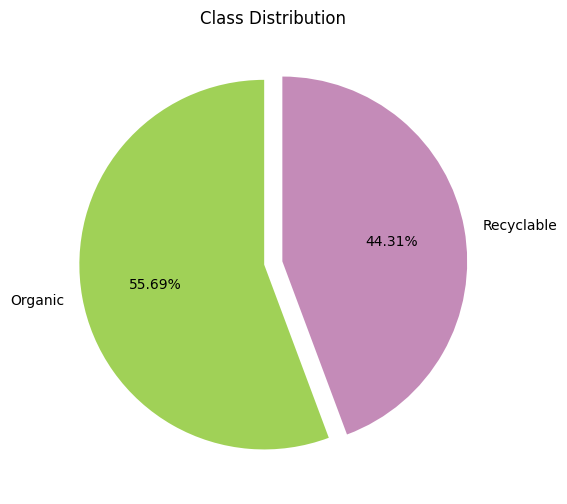

In [8]:
# Plot the distribution of classes with a pie chart

colors = ['#a0d157', '#c48bb8']
plt.figure(figsize=(6,6))
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05]*len(data.label.value_counts()))
plt.title("Class Distribution")
plt.show()

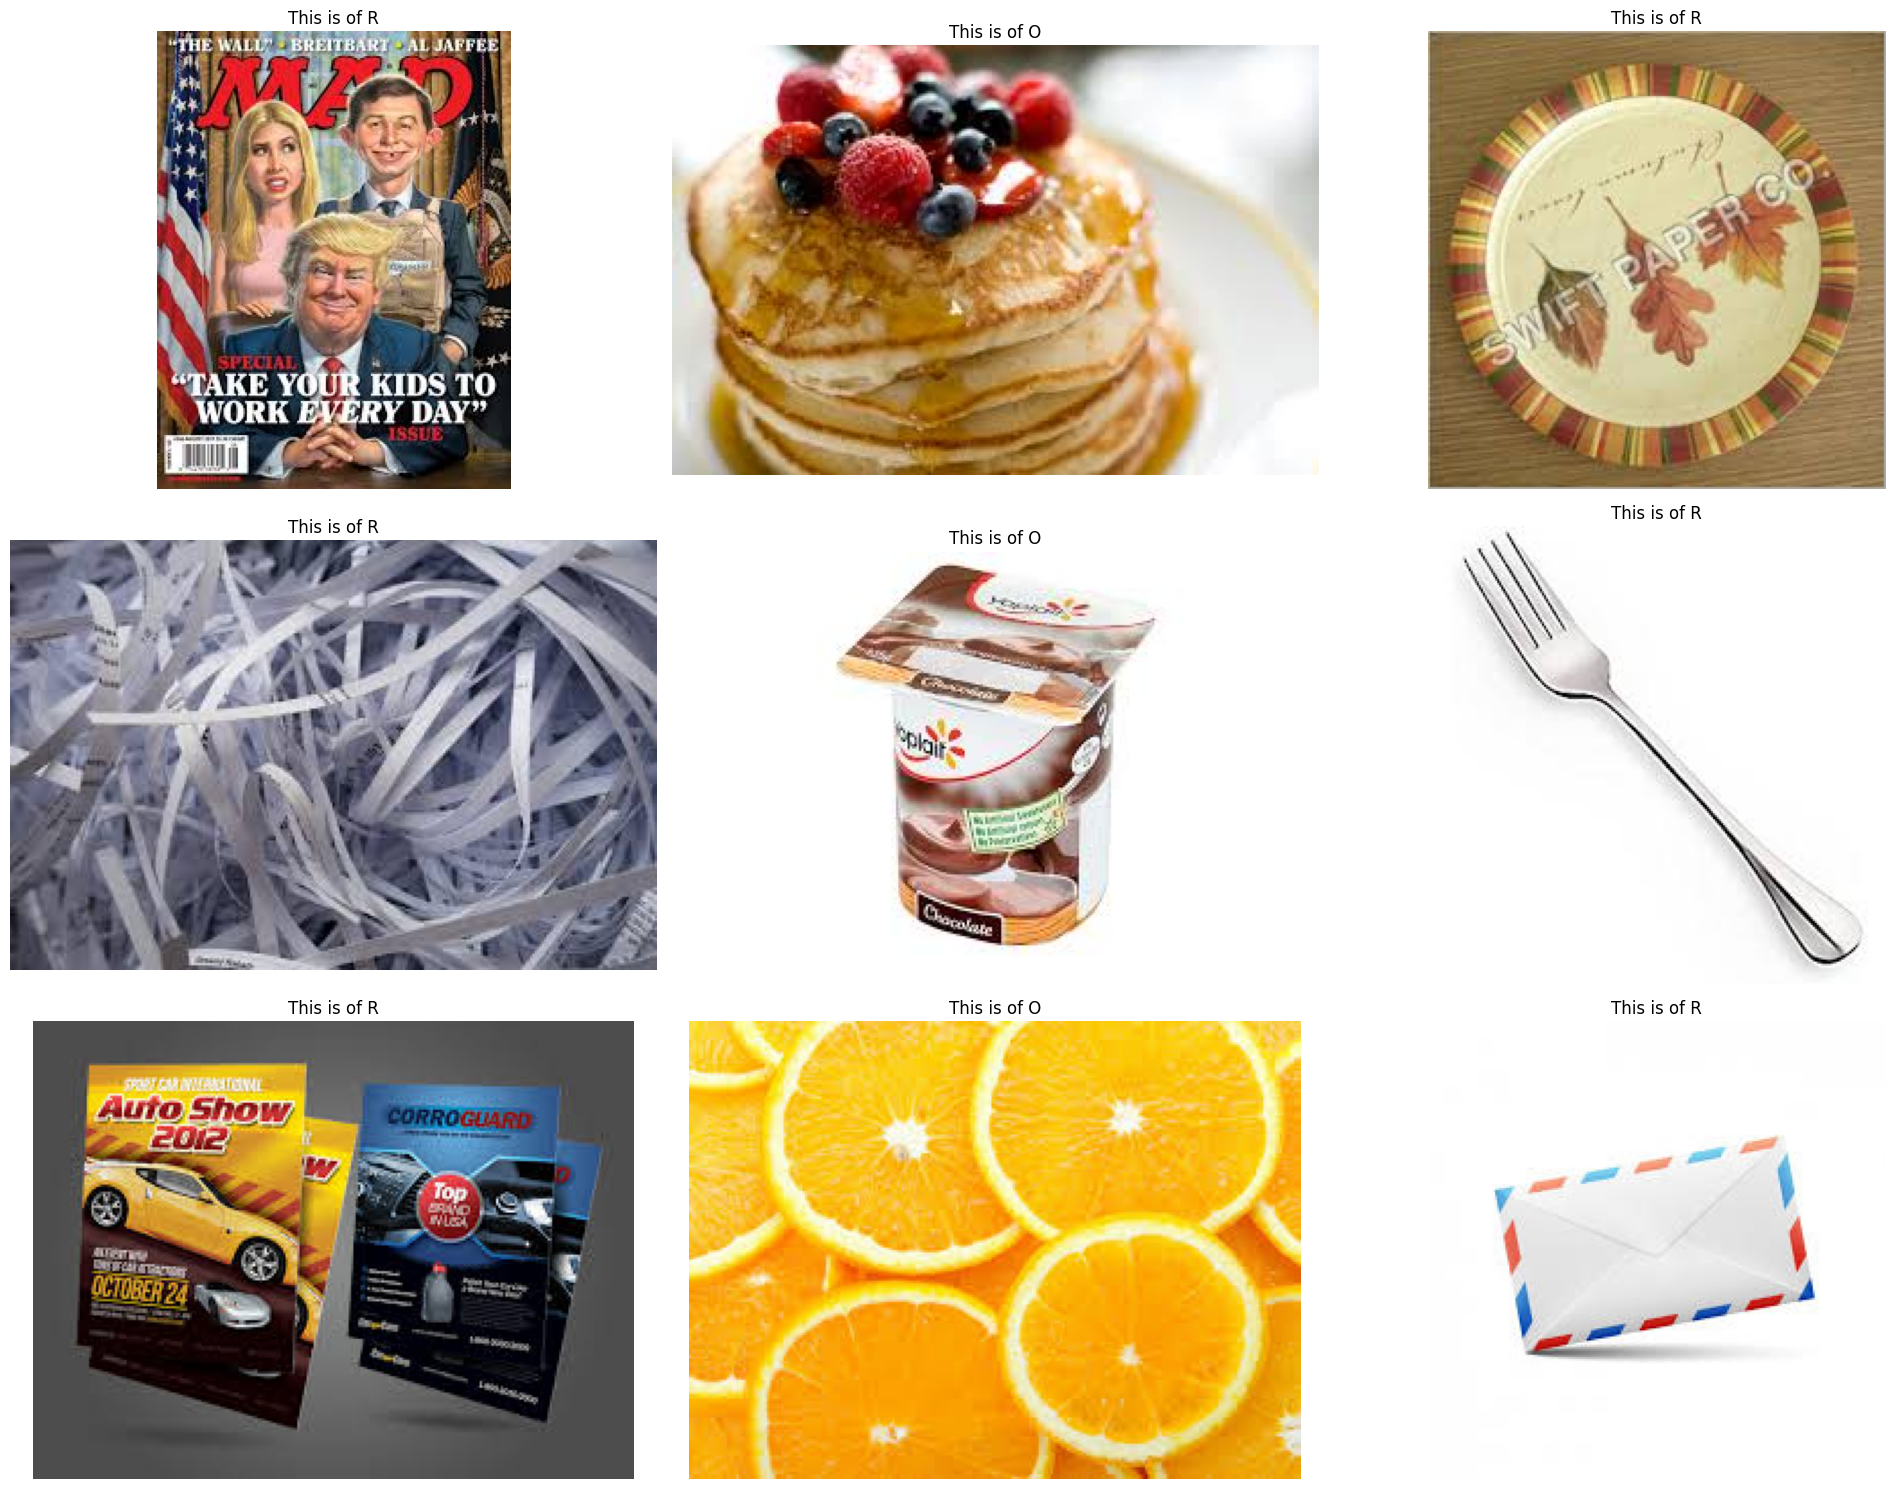

In [9]:
# Visualize a few random images with labels
plt.figure(figsize=(20, 15))
num_images = len(data)
for i in range(9):
    plt.subplot(3, 3, i+1)
    index = np.random.randint(15000)  # Use dataset length instead of fixed value
    plt.imshow(data.image[index])
    plt.title('This is of {0}'.format(data.label[index]))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 4. Model Architecture

# Build the CNN model using improved practices:

In [10]:
# - Added BatchNormalization after convolutions for better training stability.
# - Changed final activation to 'softmax' to match categorical outputs.
# - Use consistent naming and modular structure within the notebook.

def build_model(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Final Classification Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))  # Using softmax for categorical classification

    return model

# Create the model
model = build_model(input_shape=(224, 224, 3), num_classes=2)

In [11]:
# Compile the model using 'categorical_crossentropy' to match softmax activation and categorical data
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 25,802,370 (98.43 MB)

 Trainable params: 25,801,282 (98.42 MB)

 Non-trainable params: 1,088 (4.25 KB)

### 5. Data Augmentation and Generator Setup for Training

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For testing, we only normalize the images.
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Create generators using flow_from_directory
batch_size = 256
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


### 6. Model Training with Callbacks for Robustness

In [15]:
# Set up callbacks to improve training:
# - EarlyStopping to halt training when validation loss stops improving.
# - ReduceLROnPlateau to decrease learning rate on plateau.

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [16]:
# Train the model using the augmented training data and validation data.
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.7663 - loss: 0.5764 - val_accuracy: 0.4855 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8323 - loss: 0.4034 - val_accuracy: 0.5109 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8421 - loss: 0.3742 - val_accuracy: 0.5615 - val_loss: 0.7455 - learning_rate: 0.0010
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8605 - loss: 0.3425 - val_accuracy: 0.7433 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8643 - loss: 0.3370 - val_accuracy: 0.8774 - val_loss: 0.3244 - learning_rate: 0.0010


### 7. Evaluation: Plotting Accuracy and Loss

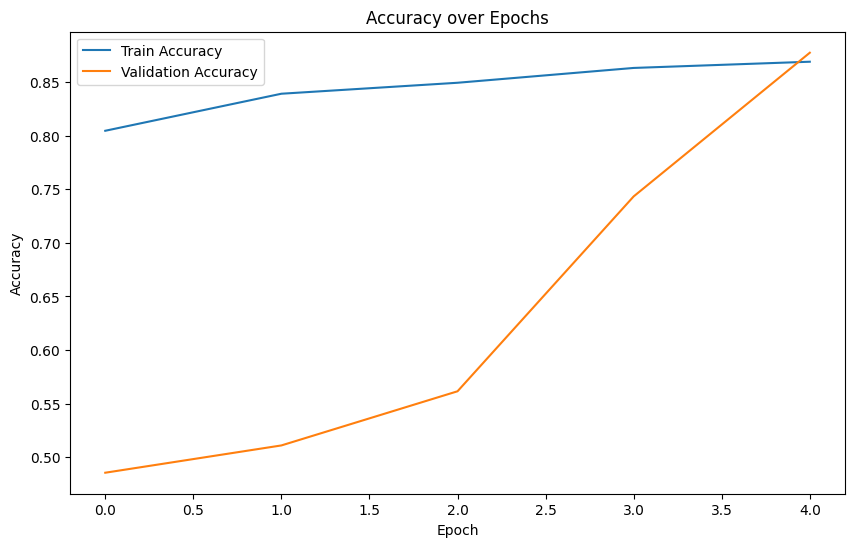

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label="Train Accuracy")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

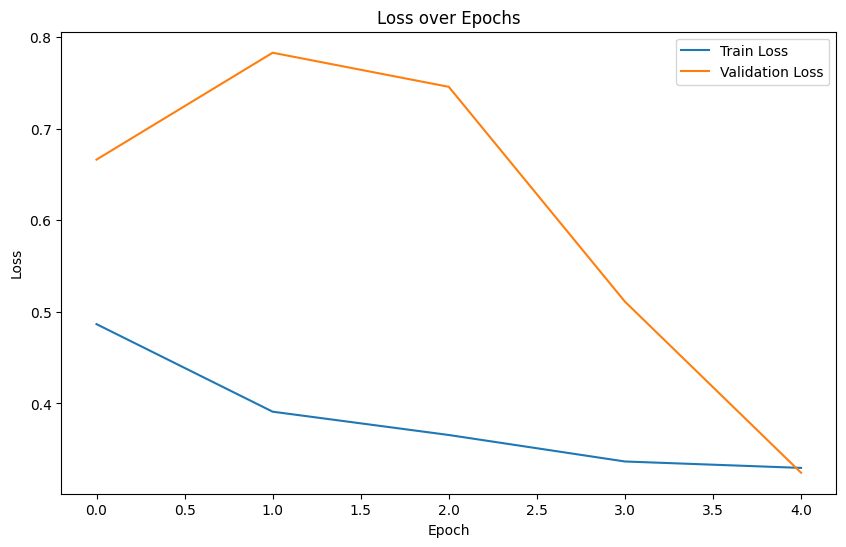

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step


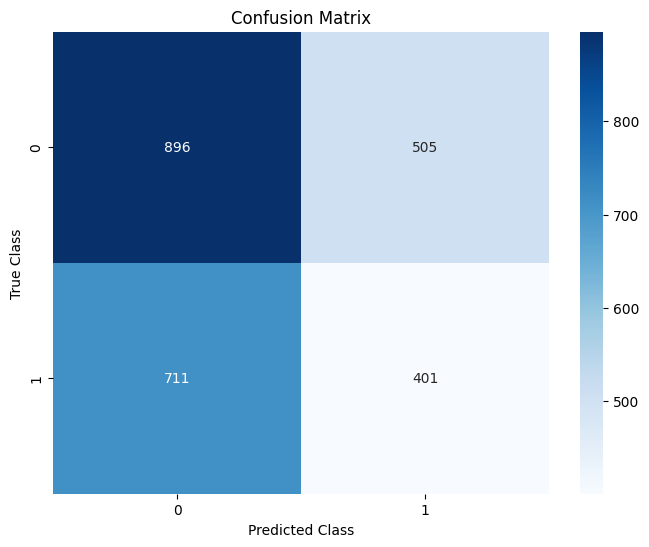

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1401
           1       0.44      0.36      0.40      1112

    accuracy                           0.52      2513
   macro avg       0.50      0.50      0.50      2513
weighted avg       0.51      0.52      0.51      2513



In [24]:
#Generate a confusion matrix and classification report for deeper evaluation

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the validation set
val_preds = model.predict(test_generator)
val_pred_classes = np.argmax(val_preds, axis=1)

# True labels from the test generator
true_classes = test_generator.classes

# Plot confusion matrix
cm = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Print classification report
print(classification_report(true_classes, val_pred_classes))

### 8. Prediction Function: Classifying a New Image

In [25]:
def predict_func(img):
    """
    Given an input image, preprocess it and output the predicted waste type.
    """
    # Preprocess the image: convert color, resize, and rescale pixel values.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = img_resized.astype('float32') / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and determine the class label
    prediction = model.predict(img_array)
    result = np.argmax(prediction)

    # Map prediction index to label
    if result == 0:
        label = "Organic Waste"
    elif result == 1:
        label = "Recyclable Waste"
    else:
        label = "Unknown"

    # Display the image with prediction
    plt.figure(figsize=(6,4))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()
    print(label)

# Example usage of prediction function:
test_img = cv2.imread("/content/vegetables.webp")
if test_img is not None:
    predict_func(test_img)
else:
    print("Test image not found or cannot be read.")


Test image not found or cannot be read.


In [27]:
model.save('WasteClassification.h5')